# Lesson 4: CNN Review and Collaborative Filtering

In this lesson, we'll end our discussion of CNN's with a review of convolutional, max pooling, and dense layers. We'll also cover dynamic learning rates, collaborative filtering, and recommender systems.

## Reviewing CNN Layers

![img](https://i.imgur.com/OGckuIn.png[/img])

Let’s begin by revisiting the VGG16 model, which only has one type of convolutional and fully connected block (summarized in the image above, taken from [A Beginner's Guide to Understanding Convolutional Neural Networks](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/)). Remember, a convolutional block is defined as:

```python
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
```

where each block is a convolutional layer stacked with an activation function and followed by a max pooling layer. 

The convolutional layer, `Convolution2D`, passes filters over an input to produce different activation features. The number of filters and their dimensions are selected and passed over an input image to produce “simpler” images with different activation features using non-linear activation functions (ReLU in this case). This is meant to reduce the possibility of overfitting our data. The filter dimensions of the following convolutional layer will then become 3x3x$n$, where $n$ is the number of filters used in the previous layer. 

The next step is to apply the max pooling layer, `MaxPooling2D`, which will decrease the resolution of our input image by finding the maximum value in each 2x2 block of pixel values. This layer is often followed by a dense (or fully connected) layer, in order to get as close to our expected output as possible, as well as another non-linear activation function. The fully connected block is defined below: 

```python
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
```

So far, mathematically, we’ve seen that dense and convolutional layers are relatively simple to evaluate as they only involve matrix multiplication. The slight complication arises when weights are optimized through backpropagation and the partial derivative of the loss function is taken with respect to each weight. This is what allows us to train really powerful models. 

## Reviewing SGD

In [1]:
%matplotlib inline
import math,sys,os,numpy as np
from numpy.random import random
from matplotlib import pyplot as plt
from __future__ import print_function, division

Let’s use the SGD algorithm on a simple linear function. We’ll use  $n$ random numbers in an array, $x$, to form the line $y = ax + b$, where $a$ and $b$ are constants. Of course, our inputs $x$ and $y$ share the same dimensions because they are linearly related. 

In Keras, we’ll start with our initial guesses of constants $a$ and $b$, $a_{guess}$ and $b_{guess}$. Given $x$, we can use these values to calculate $y_{pred}$ before taking the sum of squared errors, `sse`, of the generated output with the expected output, $y$. 

In [2]:
def lin(a,b,x): return a*x+b
def sse(y,y_pred): return ((y-y_pred)**2).sum()
def loss(y,a,b,x): return sse(y, lin(a,b,x))
def avg_loss(y,a,b,x): return np.sqrt(loss(y,a,b,x)/n)

In [3]:
a = 3.; b = 8.; n = 30
x = random(n)
y = lin(a,b,x)
a_guess = -1.; b_guess = 1.
avg_loss(y, a_guess, b_guess, x)
lr = 0.12

Once we’ve calculated $y_{pred}$, we can take the partial derivative of the loss function with respect to both $a_{guess}$ and $b_{guess}$. This will update their values in the direction opposite the gradient at a specified rate. As mentioned in previous lessons, our libraries can handle these analytic derivative calculations for us (as opposed to finite differencing) by adding a learning rate to each of our inputs to see how the output will vary. 

Here, we will make the calculations on our own:

\begin{equation*}
\frac{dl}{db_{guess}} = 2(y - a_{guess}x - b_{guess})(-1) = 2(y_{pred} - y) 
\end{equation*}
\begin{equation*}
\frac{dl}{da_{guess}} = 2(y - a_{guess}x - b_{guess})(-x) = 2(y - y_{pred})x = \frac{dl}{db_{guess}}x
\end{equation*}

In [4]:
def upd():
    global a_guess, b_guess
    y_pred = lin(a_guess, b_guess, x)
    dldb = 2 * (y_pred - y)
    dlda = x*dldb
    a_guess -= lr*dlda.mean()
    b_guess -= lr*dldb.mean()

The updated parameters (or weights) are used for the next $x$ and $y$ values in the line. One pass through the entire line is one epoch. The more epochs we run, the closer $y_{pred}$ gets to $y$ and, consequently, the lower our calculated loss will be. However, with a small learning rate, this could take a while. Slightly increasing the steps we take as we walk opposite the gradient will help minimize our loss faster. Be careful though, because if the learning rate is too large, it could lead to divergence. 

The graph below shows $y_{pred}$ after 10 updates (epochs) with a learning rate of 0.12:

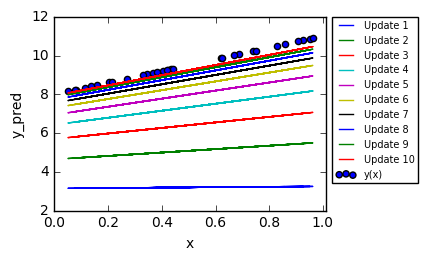

In [5]:
fig = plt.figure(dpi=100, figsize=(3.5, 2.5))
plt.scatter(x,y, label = "y(x)")
plt.axis([0, 1.01, 2, 12])
plt.xlabel("x")
plt.ylabel("y_pred")
for i in range(10): 
    upd()
    line, = plt.plot(x,lin(a_guess,b_guess,x), label = "Update " + str(i+1))
plt.legend(bbox_to_anchor=(1.36, 1.025), prop={'size': 7})

To increase the training speed while also minimizing the risk of divergence, we can use a **momentum parameter**. 

## Momentum

Setting high learning rates could result in overshooting one iteration and undershooting the next, getting into an oscillating pattern where training never converges. **Momentum** is meant to reduce the risk of this oscillation while also increasing the training speed. How does this work? Well, as we near the global minimum of our loss function, we continually decrease our momentum parameter. In this way, momentum is a technique that uses an adaptive learning rate that varies based on the weights used.

To apply momentum to our update function, we add the average from the previous gradient to the gradient term. So, when we think of the hypersurface of our loss function, which has saddle points (points where the gradient is really low but doesn't reach a minima), taking the average of the previous gradient will help us avoid bouncing between saddle points. Instead, the average will go along the trough of the function. 

## Dynamic Learning Rates

Momentum, while effective for certain parameters, doesn't effectiently optimize all parameters. A better approach is to dynamically adjust the learning rate for each parameter, using what was learned from the optimization process.

### Adagrad

**Adagrad (Adaptive Gradient Algorithm)** is a technique where the learning rate is adjusted for each individual parameter based on the previous gradients for that parameter. Specifically, we take the squares of the gradient from the previously calculated parameter (to focus on magnitude, not whether the number is positive or negative) and square root the sum (otherwise known as the **l2-norm**). For the next epoch, the new learning rate becomes the overall learning rate divided by the l2-norm of the previous update. So, if the l2-norm is large, the learning rate will be small and vice versa. Applying this to our line $y = ax + b$, the learning rate becomes:

$$lr = \frac{lr}{\frac{dl}{da} + \frac{dl}{db}}$$ 

where $\frac{dl}{da}$ and $\frac{dl}{db}$ are the partial derivatives of the loss with respect to constants $a$ and $b$.

When using adagrad and other forms of dynamic learning rates, it's good practice to intially set ```lr``` higher since it will eventually decrease when divided by the sum of the derivatives. This is one of adagrad's primary limitations: continually shrinking the learning rate for a given parameter, eventually stopping training on that parameter at some point. 

### RMSProp

**RMSProp (Root Mean Square Propagation)** is very similar to adagrad, but resolves its limitation by being able to both decrease and increase the learning rate. Like adagrad, the overall learning rate is divided by the square root of the sum of squares of the previous update gradients for a given parameter. However, RMSProp doesn’t keep track of the weighted running average of the gradients equally. Instead, it uses an exponentially weighted moving average of the previous update gradients during one epoch. So, older values contribute less than newer ones, allowing parameters to jump around the optimum without moving too far out from the minima. 

### Adam

**Adam (Adaptive Moment Estimation)** combines the benefits of momentum with those of RMSProp. Momentum is able to learn from the moving average of the gradient and continues to adjust parameters in that direction. RMSProp learns from the weighted moving average of the square of the gradients, proportionally shrinking the learning rate. Adam incorporates both of these benefits by multiplying the learning rate with the momentum and dividing by a factor related to the variance.

### Eve

**Eve** is an extension of Adam that keeps track of the change in loss function and updates the learning rate with the difference. Essentially, Eve increases the learning rate when there is little to no change in the loss function, and decreases it when the loss function fluctuates. So, when the loss function is barely changing, increasing the learning rate will effectively increase the training speed and vice versa. 

One of Eve's limitations comes when approaching a minimum. We want to take small steps to near our minimum, but Eve takes the small change in gradient as an incentive to increase the learning rate, which will bounce us out of our minimum. 

## State Farm Kaggle Competition

In this lesson, we covered Jeremy's approach to the State Farm Kaggle Competition, where we used **semi-supervised learning** to learn from unlabeled data. This was helpful to use for the competition since our given test set (unlabeled) contained 80,000 images whereas the training set (labeled) only had 20,000. 

The details on this submission can be found in my [State Farm Competition notebook](https://github.com/fdaham/fastai/blob/master/state_farm_kaggle.ipynb).


## Collaborative Filtering

We'll now move on from CNNs to deep learning in **Natural Language Processing (NLP)**. The path to NLP starts with **collaborative filtering**, which is a method used by **recommender systems** to make predictions on user interests from information collected from the user. 

### Recommender Systems

Recommender systems are essentially information filtering systems that predict user ratings, taste, and preferences. One of the main ways to build a recommender system is to use collaborative filtering. In a movie recommender system, collaborative filtering will predict your rating of a movie by finding users that have rated the same movies as you have. 

The dataset we'll be using to better understand collaborative filtering is the [Movielens Dataset](https://grouplens.org/datasets/movielens/), which contains over 100,000 movie ratings across 9,125 movies created by 671 users between January 1995 and October 2016. I've already imported and unzipped `ml-latest-small.zip` into `data/ml-small/`. Next, you'll need to import the necessary modules and define/create the data and model paths:

In [6]:
from theano.sandbox import cuda
import utils; reload(utils)
from utils import *

Using Theano backend.


In [7]:
path = 'data/ml-small/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size = 64

We can now read in the user movie ratings and movie names (for display purposes later):

In [8]:
ratings = pd.read_csv(path+'ratings.csv')
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [9]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [10]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

For this example, we'll only focus on the top 15 users and movies. Their ratings are shown below:

In [11]:
g1 = ratings.groupby('userId')['rating'].count()
g2 = ratings.groupby('movieId')['rating'].count()
topUsers = g1.sort_values(ascending=False)[:15]
topMovies=g2.sort_values(ascending=False)[:15]

In [12]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [13]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


To make learned predictions from our dataset, we use **embeddings** for each movie and user. Embeddings are vectors used to describe qualities or features of our data. We'll need to update the movie and user IDs so that they are contiguous integers, which is what we want when using embeddings:

In [14]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [15]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), ratings.userId.max(), ratings.movieId.min(), 
                                            ratings.movieId.max())
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()

For our example, we'll create embeddings with 50 elements, or **latent factors**. We rarely know exactly what attributes these factors signify. All we know is that, through gradient descent, these learned factors better predict user ratings. We can train a neural network by concatenating the latent factor embeddings and applying them to our known ratings.

In [16]:
n_factors = 50

Taking the dot product of each user/movie embedding pair for the user's movie rating allows us to train the elements of each embedding as parameters during gradient descent. Before we implement the model, let's randomly split our data into training and validation sets:

In [17]:
np.random.seed = 42
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

Now, we'll implement the simplest model; calculating the dot products of the movie and user embeddings:

In [18]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [19]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [20]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80049 samples, validate on 19955 samples
Epoch 1/1
80049/80049 [==============================] - 14s - loss: 9.8540 - val_loss: 3.8566


In [21]:
model.optimizer.lr = 0.01

In [22]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80049 samples, validate on 19955 samples
Epoch 1/3
80049/80049 [==============================] - 18s - loss: 3.1322 - val_loss: 2.0457
Epoch 2/3
80049/80049 [==============================] - 18s - loss: 2.3971 - val_loss: 1.6772
Epoch 3/3
80049/80049 [==============================] - 18s - loss: 2.2209 - val_loss: 1.5535


In [23]:
model.optimizer.lr = 0.001

In [24]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80049 samples, validate on 19955 samples
Epoch 1/6
80049/80049 [==============================] - 18s - loss: 2.1511 - val_loss: 1.4988
Epoch 2/6
80049/80049 [==============================] - 18s - loss: 2.1148 - val_loss: 1.4741
Epoch 3/6
80049/80049 [==============================] - 18s - loss: 2.0905 - val_loss: 1.4661
Epoch 4/6
80049/80049 [==============================] - 18s - loss: 2.0719 - val_loss: 1.4690
Epoch 5/6
80049/80049 [==============================] - 18s - loss: 2.0531 - val_loss: 1.4740
Epoch 6/6
80049/80049 [==============================] - 18s - loss: 2.0355 - val_loss: 1.4688


By implementing this simple concept, our model was able to achieve good results. 

### Bias

Now, how do we account for user/movie **bias**? For example, what if a movie is more popular than the others and recieves more/higher ratings? We account for this in our collaborative filtering process by adding bias terms to each user and movie embedding. These terms are treated as parameters in training and optimized during gradient descent.

In [25]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [26]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [27]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [28]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [29]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [30]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80049 samples, validate on 19955 samples
Epoch 1/1
80049/80049 [==============================] - 14s - loss: 8.8391 - val_loss: 3.1760


In [31]:
model.optimizer.lr = 0.01

In [32]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80049 samples, validate on 19955 samples
Epoch 1/6
80049/80049 [==============================] - 19s - loss: 2.5865 - val_loss: 1.6516
Epoch 2/6
80049/80049 [==============================] - 18s - loss: 1.9789 - val_loss: 1.3426
Epoch 3/6
80049/80049 [==============================] - 19s - loss: 1.8151 - val_loss: 1.2289
Epoch 4/6
80049/80049 [==============================] - 18s - loss: 1.7213 - val_loss: 1.1843
Epoch 5/6
80049/80049 [==============================] - 18s - loss: 1.6453 - val_loss: 1.1356
Epoch 6/6
80049/80049 [==============================] - 19s - loss: 1.5730 - val_loss: 1.1044


In [33]:
model.optimizer.lr = 0.001

In [34]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80049 samples, validate on 19955 samples
Epoch 1/10
80049/80049 [==============================] - 18s - loss: 1.5027 - val_loss: 1.0736
Epoch 2/10
80049/80049 [==============================] - 19s - loss: 1.4343 - val_loss: 1.0491
Epoch 3/10
80049/80049 [==============================] - 19s - loss: 1.3673 - val_loss: 1.0200
Epoch 4/10
80049/80049 [==============================] - 19s - loss: 1.3021 - val_loss: 0.9998
Epoch 5/10
80049/80049 [==============================] - 19s - loss: 1.2399 - val_loss: 0.9784
Epoch 6/10
80049/80049 [==============================] - 19s - loss: 1.1800 - val_loss: 0.9586
Epoch 7/10
80049/80049 [==============================] - 19s - loss: 1.1234 - val_loss: 0.9374
Epoch 8/10
80049/80049 [==============================] - 19s - loss: 1.0696 - val_loss: 0.9182
Epoch 9/10
80049/80049 [==============================] - 19s - loss: 1.0179 - val_loss: 0.9035
Epoch 10/10
80049/80049 [==============================] - 19s - loss: 0.9688 - val_lo

In [35]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80049 samples, validate on 19955 samples
Epoch 1/5
80049/80049 [==============================] - 19s - loss: 0.9228 - val_loss: 0.8751
Epoch 2/5
80049/80049 [==============================] - 19s - loss: 0.8797 - val_loss: 0.8603
Epoch 3/5
80049/80049 [==============================] - 20s - loss: 0.8391 - val_loss: 0.8479
Epoch 4/5
80049/80049 [==============================] - 20s - loss: 0.8019 - val_loss: 0.8390
Epoch 5/5
80049/80049 [==============================] - 20s - loss: 0.7677 - val_loss: 0.8309


As we can see, our model was able to achieve dramatically better results. We can now use the model to generate predictions on a single user and movie ID. Let's say we want to predict what user 2 would rate movie 3:

In [36]:
model.predict([np.array([2]),np.array([3])])

array([[ 3.2426]], dtype=float32)

The returned float (packed in an array) is the user movie rating out of 5. So, it looks like user 2 would most likely rate movie 3 as being mediocre. 

In [37]:
model.save_weights(model_path+'bias.h5')

### Keras' Functional API

So far, we've been creating special purpose architectures using Keras' sequential API when we could've been using simpler/more accurate standard neural networks with Keras' functional API. The functional API gives us more control over designing our architectures; you start with your input layer, list every layer between each layer, then call the output with the input from the previous layer (similar to the sequential API, but ordered differently).

With a functional API, we are able to add metadata to our CNN models (i.e. the size of our input images). In this case, we'll be concatenating the user and movie embeddings into a single vector and feed that through the network:

In [38]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [39]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [40]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80049 samples, validate on 19955 samples
Epoch 1/8
80049/80049 [==============================] - 17s - loss: 2.5617 - val_loss: 0.9175
Epoch 2/8
80049/80049 [==============================] - 28s - loss: 1.5062 - val_loss: 0.8732
Epoch 3/8
80049/80049 [==============================] - 22s - loss: 1.2479 - val_loss: 0.8409
Epoch 4/8
80049/80049 [==============================] - 20s - loss: 1.0439 - val_loss: 0.8266
Epoch 5/8
80049/80049 [==============================] - 19s - loss: 0.9149 - val_loss: 0.7992
Epoch 6/8
80049/80049 [==============================] - 20s - loss: 0.8466 - val_loss: 0.7899
Epoch 7/8
80049/80049 [==============================] - 20s - loss: 0.8165 - val_loss: 0.7921
Epoch 8/8
80049/80049 [==============================] - 20s - loss: 0.8044 - val_loss: 0.7911


The results are even better than those obtained from the dot product and bias architecture we implemented earlier. We will continue to use this functional API in the upcoming lessons. 

### Latent Factors and PCA

So, we assume that the elements of our embeddings, or latent factors, represent user/movie characteristics. We can see this through **Principle Component Analysis (PCA)**. Using PCA, we can take the first three principle components that capture the most information out of the 50 latent factors used in our example. From this, we can attempt to understand what each latent factor is "measuring".

We are able to visualize the PCA on our 50 latent factors by mapping them together. Below, you can see the first principle component mapped against the third. From the bottom left to the top right, we can see that the movies seem to be "measured" by how classic/intense they are, which leads us to believe our first principle component (mapped on the x-axis) is measuring how classic a movie is while the second (mapped on the y-axis) is measuring movies by their intensity. 

To make the analysis more interesting, we'll restrict our dataset to only contain the top 2,000 highest rated movies:

In [41]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

In [42]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
movie_pca = pca.fit(movie_emb.T).components_

In [44]:
fac0 = movie_pca[0]
fac2 = movie_pca[2]

In [45]:
import sys
stdout, stderr = sys.stdout, sys.stderr 
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr 

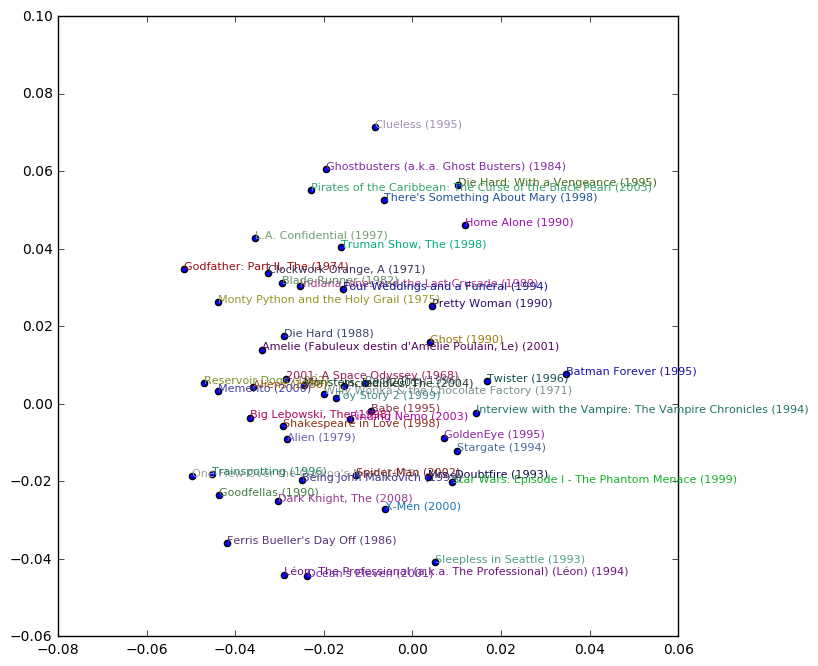

In [49]:
start = 50; end = 100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize = (8,8))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color = np.random.rand(3)*0.7, fontsize = 8)
plt.show()